In [1]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import relu
import os


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories for training and validation data
train_dir = '/content/drive/MyDrive/K-Pipelines-main/Standard/train'
valid_dir = '/content/drive/MyDrive/K-Pipelines-main/Standard/valid'  # Separate validation directory

# ImageDataGenerator for training (no validation split)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
)

# ImageDataGenerator for validation (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # Xception default size
    batch_size=16,
    class_mode='binary',
)

# Validation data generator (using the separate validation directory)
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary',
)


Found 480 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
# Load the pre-trained Xception model without top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation=relu)(x)  # Mish activation for experimentation
x = Dropout(0.5)(x)  # Dropout for regularization

# Output layer for binary classification (1 output unit with sigmoid)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('1024_relu_xception_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint],
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.6405 - loss: 0.6051 - val_accuracy: 0.9000 - val_loss: 0.2915
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 469ms/step - accuracy: 0.8644 - loss: 0.3244 - val_accuracy: 0.9333 - val_loss: 0.2355
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 430ms/step - accuracy: 0.8513 - loss: 0.2933 - val_accuracy: 0.8667 - val_loss: 0.2936
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.9336 - loss: 0.1936 - val_accuracy: 0.9500 - val_loss: 0.2151
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - accuracy: 0.9456 - loss: 0.1374 - val_accuracy: 0.9000 - val_loss: 0.2222
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 433ms/step - accuracy: 0.9438 - loss: 0.1510 - val_accuracy: 0.9333 - val_loss: 0.2306
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 436ms/step - accuracy: 0.9507 - loss: 0.1513 - val_accuracy: 0.9333 - val_loss: 0.2296
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step - accuracy: 0.9497 - loss: 0.1381 - val_accurac

In [ ]:
# Define the ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_dir = '/content/drive/MyDrive/K-Pipelines-main/Standard/test'  # Update with your test data directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),  # Same size used for training
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Important: Do not shuffle test data to keep order
)

Found 60 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load the best model saved during training
model = load_model('/content/1024_relu_xception_model.keras')

# Recompile the model with AUC metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Evaluate the model
test_loss, test_accuracy, test_auc = model.evaluate(test_generator)

# Print results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 650ms/step - AUC: 0.7618 - accuracy: 0.7971 - loss: 0.3728
Test Loss: 0.3376794159412384
Test Accuracy: 0.800000011920929
Test AUC: 0.9349277019500732


In [ ]:
# Define the ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_dir = '/content/drive/MyDrive/K-Pipelines-main/Standard/test'  # Update with your test data directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),  # Same size used for training
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Important: Do not shuffle test data to keep order
)



Found 60 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
model = load_model('/content/1024_relu_xception_model.keras')




In [ ]:
# Evaluate the model
results = model.evaluate(test_generator)
test_loss, test_accuracy = results  # Extract all three returned values

# Print the results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 589ms/step - accuracy: 0.7971 - loss: 0.3728
Test Loss: 0.3376794159412384
Test Accuracy: 0.800000011920929
Test AUC: 0.9349277019500732


In [ ]:
# Load and preprocess an image for prediction
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(299, 299))

    # Convert the image to array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the shape of data in the model
    img_array = np.expand_dims(img_array, axis=0)

    # Rescale the image
    img_array /= 255.0

    return img_array

def predict_image(img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Make a prediction
    prediction = model.predict(img_array)

    # Corrected condition based on class indices
    if prediction[0] > 0.5:
        return "No Corrosion"  # Class 1
    else:
        return "Corrosion"  # Class 0


img_path = '/content/drive/MyDrive/K-Pipelines-main/Standard/train/corrosion/04a735c6-d0c5-4fe0-95d5-88e65d749c2e_png_jpg.rf.eeb48b3cd59920355a46a3d7d094db8b.jpg'
result = predict_image(img_path)
print(f"The model predicts: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
The model predicts: Corrosion


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
Confusion Matrix:
[[24  7]
 [ 5 24]]
Classification Report:
              precision    recall  f1-score   support

No corrosion       0.83      0.77      0.80        31
   Corrosion       0.77      0.83      0.80        29

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



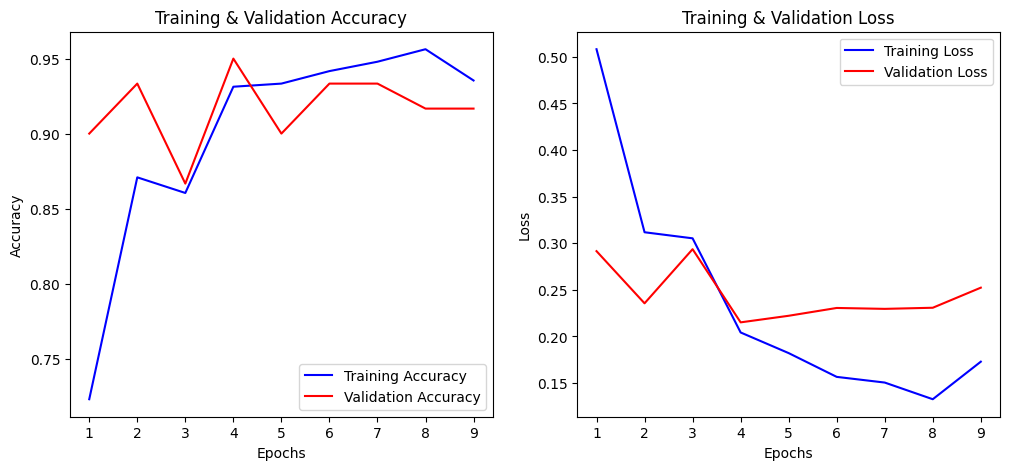

Final Training Loss: 0.1729
Final Training Accuracy: 0.9354
Final Validation Loss: 0.2523
Final Validation Accuracy: 0.9167


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

#Confusion Matrix & Classification Report
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to class labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_true, y_pred, target_names=["No corrosion", "Corrosion"])
print("Classification Report:")
print(report)

# Plot Loss and Accuracy Curves
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot Training & Validation Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call function to plot graphs
plot_training_history(history)

# Final Training & Validation Accuracy and Loss
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


In [ ]:
print(train_generator.class_indices)

{'corrosion': 0, 'no_corrosion': 1}
